In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pyzx as zx
import time
import random
from fractions import Fraction
from tqdm import tqdm
%matplotlib inline

In [2]:
class CircuitGenerator:
    def __init__(self, qubits: int, depth: int, dense: bool = False):
        assert qubits > 0, "The number of qubits must be positive."
        assert depth > 0, "The depth must be positive."
        self.__dense = dense
        self.__qubits = qubits
        self.__depth = depth

    def __call__(self) -> zx.graph.base.BaseGraph:
        if self.__dense:
            return self.__dense_graph(qubits = self.__qubits, layers_count = self.__depth)
        else:
            return zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits,
                                                      depth = self.__depth,
                                                      clifford = False).to_graph()

    def __dense_graph(self, qubits, layers_count: int = 10) -> zx.graph.base.BaseGraph:
        g = zx.Graph()
        inputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 0)
                  for i in range(qubits)]
        outputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 4 * layers_count + 1)
                   for i in range(qubits)]

        # This local function adds a new layer having a particular shape;
        # we need the previous `qubits` nodes along each line, together with the
        # index `cnt` of the layer we need to construct.
        # It returns the new last vertex on each line.
        def add_layer(prev, cnt):
            # Create the vertices.
            layer = [g.add_vertex(zx.VertexType.Z,
                            qubit = (i + 1) // 2,
                            row = 4 * cnt + (1 if i % 4 < 2 else 2)) for i in range(2 * qubits - 2)]
            # Construct the edges between these `2 * qubits - 2` vertices in a zig-zag shape.
            H, S = zx.EdgeType.HADAMARD, zx.EdgeType.SIMPLE
            for i in range(2 * qubits - 3):
                g.add_edge(g.edge(layer[i], layer[i + 1]), edgetype = H if i % 2 == 0 else S)

            # We collect the first (front) and the last (end) vertex on each of the `qubits` lines.
            front_indices, end_indices = [], []
            front_indices.append(0)
            end_indices.append(0)
            for i in range(1, qubits - 1):
                front_indices.append(2 * i - (i & 1))
                end_indices.append(2 * i - (i + 1 & 1))
            front_indices.append(2 * qubits - 3)
            end_indices.append(2 * qubits - 3)

            # Connect the previous layer (or the inputs if this is to be the first one)
            # to the current layer.
            for i in range(qubits):
                g.add_edge(g.edge(prev[i], layer[front_indices[i]]), zx.EdgeType.SIMPLE)

            # Add two randomised red vertices along each wire:
            # Their phases are k * pi / 4 and l * pi / 4, where k and l are independent
            # and uniformly distributed over {0, 1, ..., 7}.
            prev = []
            for i in range(qubits):
                [k, l] = [g.add_vertex(zx.VertexType.X,
                                       phase = Fraction(random.randrange(8), 4),
                                       qubit = i,
                                       row = 4 * cnt + j + 3) for j in range(2)]
                g.add_edge(g.edge(layer[end_indices[i]], k), edgetype = zx.EdgeType.SIMPLE)
                g.add_edge(g.edge(k, l), edgetype = zx.EdgeType.SIMPLE)
                prev.append(l)
            return prev

        # Add all layers whilst updating the prev vertices.
        prev = inputs
        for cnt in range(layers_count):
            prev = add_layer(prev, cnt)

        # Connect the prev vertices with the outputs.
        for i in range(qubits):
            g.add_edge(g.edge(prev[i], outputs[i]), zx.EdgeType.SIMPLE)

        # Set the inputs and outputs
        g.auto_detect_io()
        return g

In [3]:
class RandomCircuitBenchmark:
    def __init__(self, repeat: int = 10, dense: bool = False, full_reduce: bool = False,
                 tensorfy_strategies = ('naive', 'rw-greedy-b2t', 'rw-greedy-linear'),
                 quimb_strategies = ('hyper-greedy', 'hyper-kahypar', 'optimal')):
        self.__repeat = repeat
        self.__dense = dense
        self.__full_reduce = full_reduce
        self.__tensorfy_strategies = tensorfy_strategies
        self.__quimb_strategies = quimb_strategies
        self.__all_strategies = self.__tensorfy_strategies + ('quimb',) + self.__quimb_strategies

    def run_with_qubits(self, depth, qubits_range):
        times_dict = {strategy: [] for strategy in self.__all_strategies}
        self.__depth = depth
        for qubits in tqdm(qubits_range):
            self.__qubits = qubits
            self.__generator = CircuitGenerator(qubits, depth, self.__dense)
            time_dict = self.__run_tensors()
            for strategy in time_dict.keys():
                times_dict[strategy].append(time_dict[strategy])
        return times_dict

    def run_with_depths(self, qubits, depth_range):
        times_dict = {strategy: [] for strategy in self.__all_strategies}
        self.__qubits = qubits
        for depth in tqdm(depth_range):
            self.__depth = depth
            self.__generator = CircuitGenerator(qubits, depth, self.__dense)
            time_dict = self.__run_tensors()
            for strategy in time_dict.keys():
                times_dict[strategy].append(time_dict[strategy])
        return times_dict

    def __run_tensor(self):
        # Generate a circuit and convert it to a graph object
        g = self.__generator()
        g.apply_state("0" * self.__qubits)  # use kets 0 as inputs
        g.apply_effect("0" * self.__qubits)  # use bras 0 as outputs
        zx.to_gh(g)  # get rid of red spiders
        if self.__full_reduce:
            zx.full_reduce(g)

        value_dict = dict()
        time_dict = dict()
        
        # Profiling tensorfy strategies
        for strategy in self.__tensorfy_strategies:
            t = time.time()
            value_dict[strategy] = g.to_tensor(strategy=strategy)
            time_dict[strategy] = time.time() - t

        # Profiling basic quimb
        t = time.time()
        value_dict['quimb'] = zx.to_quimb_tensor(g).contract(output_inds=())
        time_dict['quimb'] = time.time() - t

        # Profiling quimb strategies
        for strategy in self.__quimb_strategies:
            t = time.time()
            tn = zx.to_quimb_tensor(g)
            tn.full_simplify_('ADCRS', output_inds = (), equalize_norms = True)
            value_dict[strategy] = tn.contract(optimize = strategy, output_inds = ())
            time_dict[strategy] = time.time() - t

        # Assert correctness and update the list fields.
        for strategy in self.__tensorfy_strategies:
            assert abs(value_dict[strategy] - value_dict['quimb']) < 1e-9, f"Tensorfy ({strategy}) produces incorrect result"
        for strategy in self.__quimb_strategies:
            assert abs(value_dict[strategy] - value_dict['quimb']) < 1e-9, f"Quimb ({strategy}) produces incorrect result"
        for strategy in time_dict.keys():
            self.__times_dict[strategy].append(time_dict[strategy])

    def __run_tensors(self):
        self.__times_dict = {strategy: [] for strategy in self.__all_strategies}
        for _ in range(self.__repeat):
            self.__run_tensor()
        return {strategy: np.mean(self.__times_dict[strategy]) for strategy in self.__times_dict.keys()}

    def display_plot(self, times_dict, rng, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if has_qubits else \
            ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        for strategy in self.__tensorfy_strategies:
            ax.plot(rng, times_dict[strategy], label=f'Tensorfy ({strategy})')
        ax.plot(rng, times_dict['quimb'], label=f'Quimb (basic)')
        for strategy in self.__quimb_strategies:
            ax.plot(rng, times_dict[strategy], '--', label=f'Quimb ({strategy})')
        ax.set_yscale('log')
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(f"From {rng[0]} to {rng[-1]} {var_type}, fixed {fixed_type} of {fixed_quant}")
        ax.legend()

    def get_table(self, var, range_var, times_dict):
        def list_to_row(name, elems):
            s = name.ljust(15)
            is_first = True
            for x in elems:
                if is_first:
                    is_first = False
                else:
                    s += " | "
                s += str(x).rjust(7) if isinstance(x, int) else "{:.3f}".format(x).rjust(7)
            s += '\n'
            return s

        s = list_to_row(f"{var}:", range_var)
        for strategy in self.__tensorfy_strategies:
            s += list_to_row(f"Tensorfy ({strategy}) times:", times_dict[strategy])
        s += list_to_row("Quimb (basic) times:", times_dict['quimb'])
        for strategy in self.__quimb_strategies:
            s += list_to_row(f"Quimb ({strategy}) times:", times_dict[strategy])
        return s

    def display_table_and_plot(self, times_dict, rng, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("Qubits", "depth", self.__depth) if has_qubits else \
            ("Depth", "qubits", self.__qubits)
        str_full_reduce = " (with full_reduce = True)" if self.__full_reduce else ""
        print(f"For {fixed_quant} {fixed_type}{str_full_reduce}:\n")
        print(self.get_table(var_type, rng, times_dict))
        self.display_plot(times_dict, rng, has_qubits)

    def test(self, has_qubits: bool, fixed_quant: int, rng, with_table: bool = False):
        times_dict = self.run_with_qubits(fixed_quant, rng) if has_qubits \
            else self.run_with_depths(fixed_quant, rng)
        if with_table:
            self.display_table_and_plot(times_dict, rng, has_qubits)
        else:
            self.display_plot(times_dict, rng, has_qubits)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.30it/s]


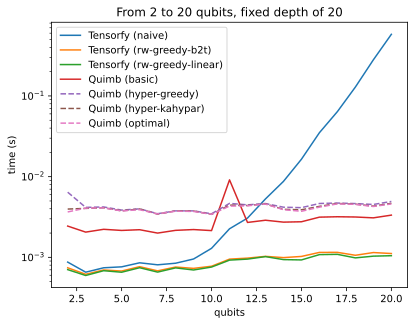

In [31]:
cb = RandomCircuitBenchmark()
cb.test(has_qubits = True, fixed_quant = 20, rng = range(2, 21))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


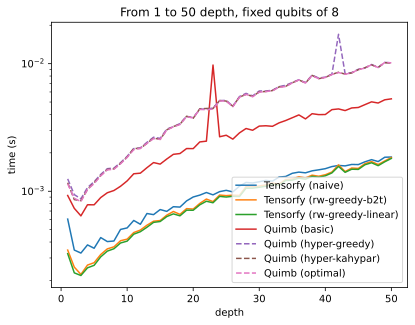

In [32]:
cb = RandomCircuitBenchmark()
cb.test(has_qubits = False, fixed_quant = 8, rng = range(1, 51))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.02s/it]


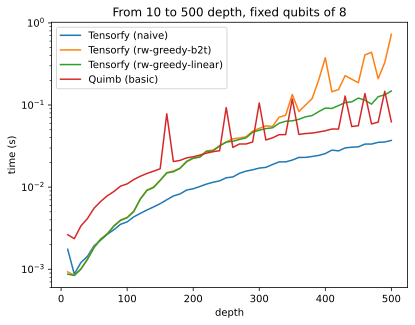

In [9]:
cb = RandomCircuitBenchmark(quimb_strategies = ())
cb.test(has_qubits = False, fixed_quant = 8, rng = range(10, 501, 10))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.54it/s]


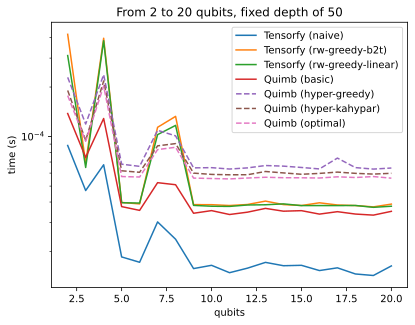

In [33]:
cb = RandomCircuitBenchmark(full_reduce = True)
cb.test(has_qubits = True, fixed_quant = 50, rng = range(2, 21))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.34it/s]


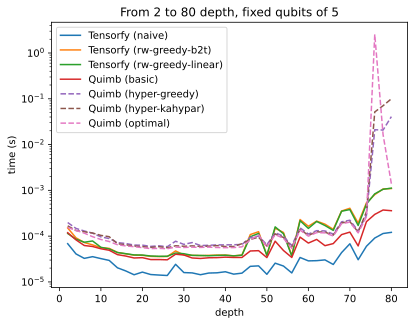

In [35]:
cb = RandomCircuitBenchmark(full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 5, rng = range(2, 81, 2))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.25it/s]


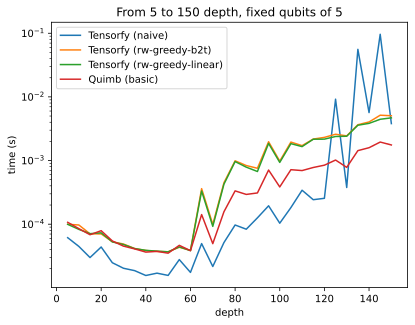

In [37]:
cb = RandomCircuitBenchmark(quimb_strategies=(), full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 5, rng = range(5, 151, 5))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.10s/it]


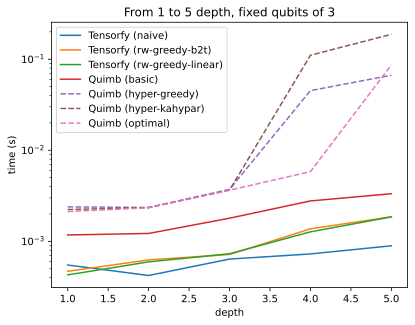

In [5]:
cb = RandomCircuitBenchmark(dense = True)
cb.test(has_qubits = False, fixed_quant = 3, rng = range(1, 6))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:49<00:00,  5.80s/it]


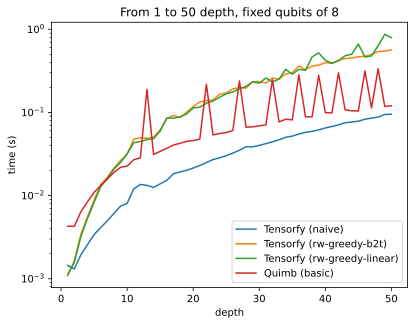

In [15]:
cb = RandomCircuitBenchmark(quimb_strategies = (), dense = True)
cb.test(has_qubits = False, fixed_quant = 8, rng = range(1, 51))